In [17]:
import pandas as pd
from obspy import read, UTCDateTime
import matplotlib.pyplot as plt
from matplotlib import mlab
import numpy as np
import glob
import librosa

In [18]:
data_path='/network/projects/aia/whale_call/RAW/'
center_time = UTCDateTime("20210309112910")
detection_win_len = 120 # lenth of detection window in s
station_name = 'PMAQ'
data_year = center_time.year
data_month = center_time.month
data_day = center_time.day
start_time = center_time - detection_win_len/2
end_time = center_time + detection_win_len/2

In [19]:
date_string = '%s%02d%02d'%(data_year,data_month,data_day)
file_patterns = data_path+date_string+'/'+ '%s.%02d.%02d.CN'%(data_year,data_month,data_day)+'*'+station_name+'*.SAC'
sac_files = glob.glob(file_patterns)

In [20]:
sac_data_allchannels = read(sac_files[0],starttime=start_time,endtime=end_time)
for file_id in range(1,len(sac_files)):
    sac_data_allchannels += read(sac_files[file_id],starttime=start_time,endtime=end_time)

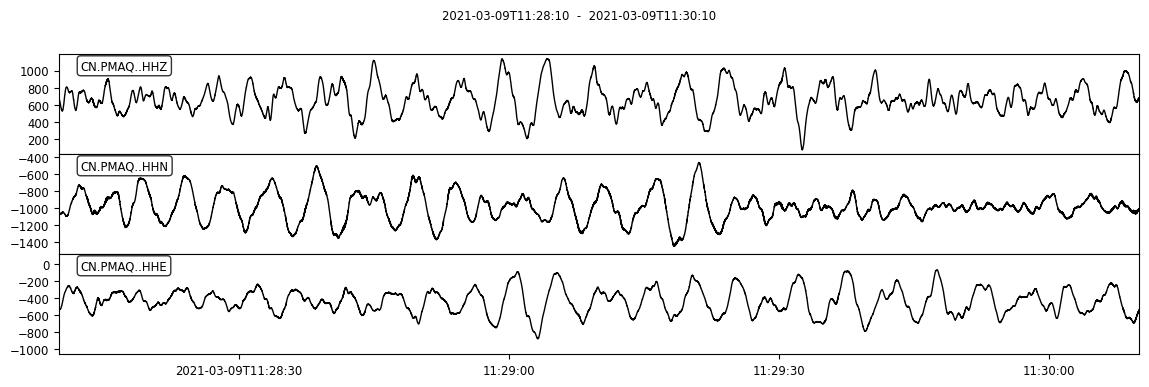

In [21]:
sac_data_allchannels.plot(size=(1200, 400));

## Perform Bandpass filtering

In [22]:
freq_min = 12
freq_max = 32

sac_data_allchannels_filter = []
for trace in sac_data_allchannels:
    trace_filt =trace.copy()
    trace_filt.filter('bandpass', freqmin=freq_min, freqmax=freq_max,zerophase=True)
    sac_data_allchannels_filter.append(trace_filt)

### Visualize the filtering for a single channel

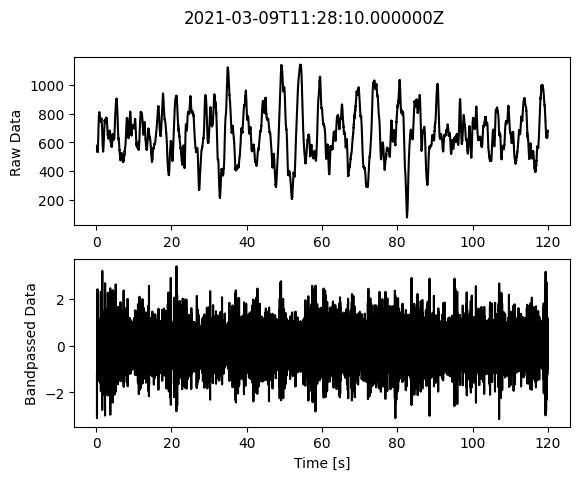

In [23]:
freq_min = 12
freq_max = 32
tr = sac_data_allchannels[1]
tr_filt = sac_data_allchannels_filter[1]
# tr_filt = tr.copy()
# tr_filt.filter('bandpass', freqmin=freq_min, freqmax=freq_max,zerophase=True)

# Now let's plot the raw and filtered data...
time_truncated =20 # truncate the first 20 samples  
                    #(~0.2s) to neglect the large spike due to a bandpass filter
t = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
plt.subplot(211)
plt.plot(t[time_truncated:], tr.data[time_truncated:], 'k')
plt.ylabel('Raw Data')
plt.subplot(212)
plt.plot(t[time_truncated:], tr_filt.data[time_truncated:], 'k')
plt.ylabel('Bandpassed Data')
plt.xlabel('Time [s]')
plt.suptitle(tr.stats.starttime)
plt.show()

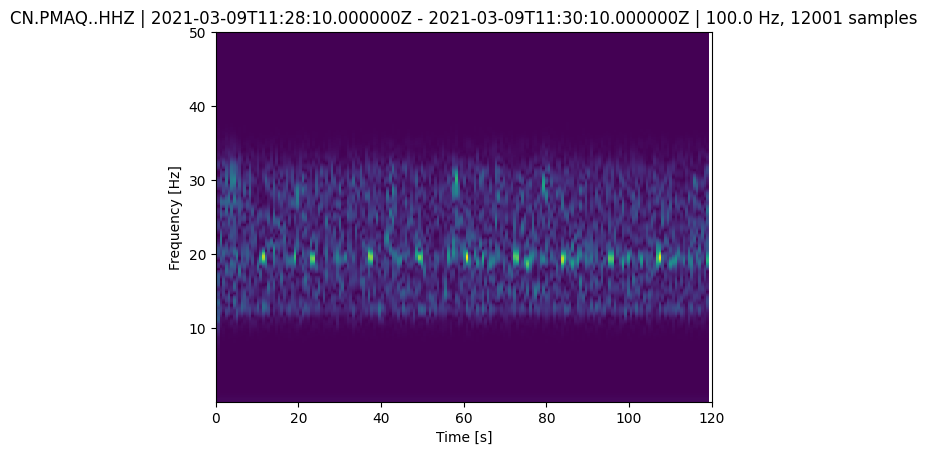

In [24]:
tr_filt.spectrogram(samp_rate=100,wlen=1,per_lap=0.5,dbscale=False)

## Spectrogram Calculated Manually

### Data and parameters

In [25]:
import math
def _nearest_pow_2(x):
    """
    Find power of two nearest to x

    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0

    :type x: float
    :param x: Number
    :rtype: int
    :return: Nearest power of 2 to x
    """
    a = math.pow(2, math.ceil(np.log2(x)))
    b = math.pow(2, math.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

signal_data = tr_filt.data
sample_rate = tr_filt.stats.sampling_rate
win_length = 1  # window length in s
hop_length = 0.5 # hop length in s, i.e. the distance between each segment.
win_size = int(win_length*sample_rate)
nfft = int(_nearest_pow_2(win_size))
hop_size = int(hop_length*sample_rate)



### Librosa spectrogram

(65, 241)

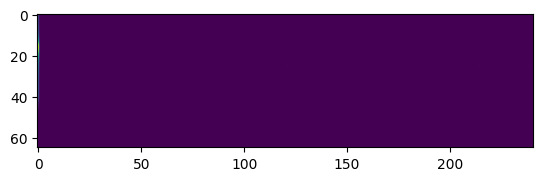

In [26]:
import librosa.display     
spec=librosa.stft(signal_data,
                 n_fft=nfft,
                 win_length = win_size, 
                 hop_length=hop_size)
spec_power = np.abs(spec)**2
plt.imshow(spec_power)
spec_power.shape

## Mlab/Obspy Spectrogram

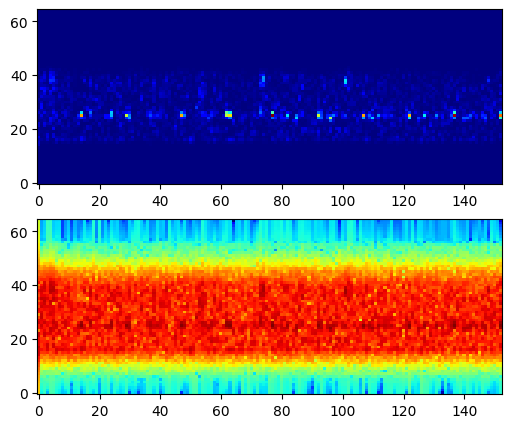

In [27]:
import os
import math

import numpy as np
from matplotlib import mlab
from matplotlib.colors import Normalize

from obspy.imaging.cm import obspy_sequential

sample_rate = float(sample_rate)

spec_mlab, freq, time = mlab.specgram(signal_data, 
                                      Fs=sample_rate, 
                                      NFFT=nfft,
                                      noverlap=hop_size,
                                      mode='magnitude')
spec_power_mlab = spec_mlab**2
spec_power_mlab_db =10*np.log10(spec_power_mlab)


spec_power_mlab.shape

fig,ax=plt.subplots(2,1,figsize=(6,5))
ax[0].imshow(spec_power_mlab, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
ax[1].imshow(spec_power_mlab_db, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')


## Custom Code

/tmp/ipykernel_60907/1877780307.py:24: RuntimeWarning: divide by zero encountered in log10
  result_db = 10*np.log10(result)          # scale to db


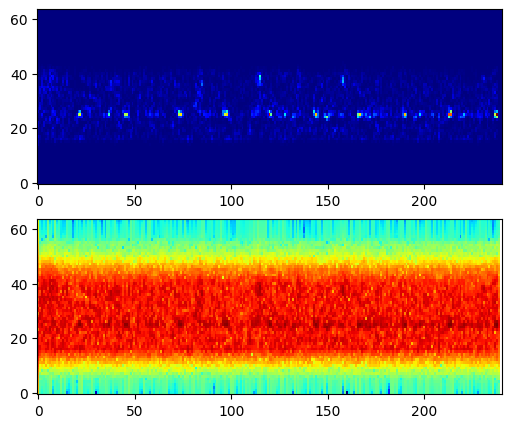

In [28]:
data = signal_data
fs = sample_rate
fft_size= nfft
pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
t_max = len(data) / np.float32(fs)

window = np.hanning(fft_size)  # our half cosine window
inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result

for i in range(total_segments):                      # for each segment
    current_hop = hop_size * i                        # figure out the current segment offset
    segment = proc[current_hop:current_hop+fft_size]  # get the current segment
    windowed = segment * window                       # multiply by the half cosine function
    # padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
    spectrum = np.fft.fft(windowed) / fft_size          # take the Fourier Transform and scale by the number of samples
    autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
    result[i, :] = autopower[:fft_size]               # append to the results array


result_db = 10*np.log10(result)          # scale to db

fig,ax=plt.subplots(2,1,figsize=(6,5))
ax[0].imshow(result[:,:64].T, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
ax[1].imshow(result_db[:,:64].T, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')


## The sum of power spectrogram of all channels

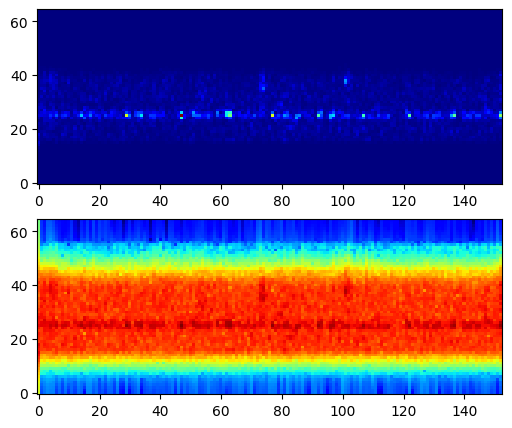

In [29]:
spec_power_sum = 0
for trace in sac_data_allchannels_filter:
    signal_data = trace.data
    spec_mlab, freq, time = mlab.specgram(signal_data, 
                                        Fs=sample_rate, 
                                        NFFT=nfft,
                                        noverlap=hop_size,
                                        mode='magnitude')
    spec_power_mlab = spec_mlab**2
    spec_power_sum += spec_power_mlab

spec_power_sum_db = 10*np.log10(spec_power_sum)

fig,ax=plt.subplots(2,1,figsize=(6,5))
ax[0].imshow(spec_power_sum, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
ax[1].imshow(spec_power_sum_db, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
